In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats

import dask.dataframe as dd
from pathlib import Path
import glob

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

import re

In [2]:
import sys

sys.path.append("../src")

In [3]:
import data_handling as dh
import subsampling as ss
from core import SITE_NAMES, DC_COLOR_MAPPINGS, FREQ_GROUPS

import bout_clustering as bt_clustering
import bout_plotting as bt_plt
from cli import get_file_paths
import plotting
import pipeline

In [4]:
cycle_lengths = [1800, 360]
percent_ons = [0.1667]
specific_dc_tag = "1800of1800"

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = False
pipeline_params["read_csv"] = False
pipeline_params["save_activity_grid"] = True
pipeline_params["save_presence_grid"] = True
pipeline_params["save_dc_night_comparisons"] = True
pipeline_params["save_activity_dc_comparisons"] = True
pipeline_params["save_presence_dc_comparisons"] = True
pipeline_params["show_plots"] = True
pipeline_params["show_PST"] = True

data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['resolution_in_min'] = '30'
data_params['index_time_block_in_secs'] = '5'
data_params['recording_start'] = '02:00'
data_params['recording_end'] = '13:30'


site_key = 'Carp'
type_key = 'LF1'
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key

file_paths = get_file_paths(data_params)

In [5]:
fig_details = dict()
fig_details['site_name'] = 'mock'
fig_details['freq_group'] = type_key + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 2000

In [6]:
location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, '300of1800')
location_df

,start_time_wrt_ref,end_time_wrt_ref,freq_group,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card
0,106.9265,106.9415,LF1,2022-07-13 06:30:00,2022-07-13 06:31:46.926500000,2022-07-13 06:31:46.941500000,106.9265,106.9415,25468.0,29596.0,Echolocation,Nyctalus leisleri,0.459,0.600,-1,/mnt/ubna_data_01/recover-20220715/UBNA_008/20...,Carp Pond,NaN,NaN
0,0.6215,0.6354,LF1,2022-07-13 07:30:00,2022-07-13 07:30:00.621500000,2022-07-13 07:30:00.635400000,0.6215,0.6354,25468.0,28948.0,Echolocation,Nyctalus leisleri,0.489,0.572,-1,/mnt/ubna_data_01/recover-20220715/UBNA_008/20...,Carp Pond,NaN,NaN
1,0.8795,0.8939,LF1,2022-07-13 07:30:00,2022-07-13 07:30:00.879500000,2022-07-13 07:30:00.893900000,0.8795,0.8939,26328.0,29806.0,Echolocation,Nyctalus leisleri,0.518,0.645,-1,/mnt/ubna_data_01/recover-20220715/UBNA_008/20...,Carp Pond,NaN,NaN
2,1.1295,1.1440,LF1,2022-07-13 07:30:00,2022-07-13 07:30:01.129500000,2022-07-13 07:30:01.144000000,1.1295,1.1440,26328.0,29369.0,Echolocation,Nyctalus leisleri,0.476,0.556,-1,/mnt/ubna_data_01/recover-20220715/UBNA_008/20...,Carp Pond,NaN,NaN
3,3.0665,3.0818,LF1,2022-07-13 07:30:00,2022-07-13 07:30:03.066500000,2022-07-13 07:30:03.081800000,3.0665,3.0818,26328.0,29496.0,Echolocation,Nyctalus leisleri,0.400,0.503,-1,/mnt/ubna_data_01/recover-20220715/UBNA_008/20...,Carp Pond,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,289.6935,289.7125,LF1,2022-10-17 05:00:00,2022-10-17 05:04:49.693500000,2022-10-17 05:04:49.712500000,289.6935,289.7125,26328.0,28985.0,Echolocation,Nyctalus leisleri,0.591,0.619,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10.0
5,290.5115,290.5307,LF1,2022-10-17 05:00:00,2022-10-17 05:04:50.511499999,2022-10-17 05:04:50.530699999,290.5115,290.5307,26328.0,28925.0,Echolocation,Nyctalus leisleri,0.681,0.711,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10.0
6,291.3305,291.3479,LF1,2022-10-17 05:00:00,2022-10-17 05:04:51.330500000,2022-10-17 05:04:51.347900000,291.3305,291.3479,26328.0,29139.0,Echolocation,Nyctalus leisleri,0.546,0.588,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10.0
7,292.3925,292.4130,LF1,2022-10-17 05:00:00,2022-10-17 05:04:52.392500000,2022-10-17 05:04:52.413000000,292.3925,292.4130,26328.0,28746.0,Echolocation,Nyctalus leisleri,0.540,0.577,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10.0


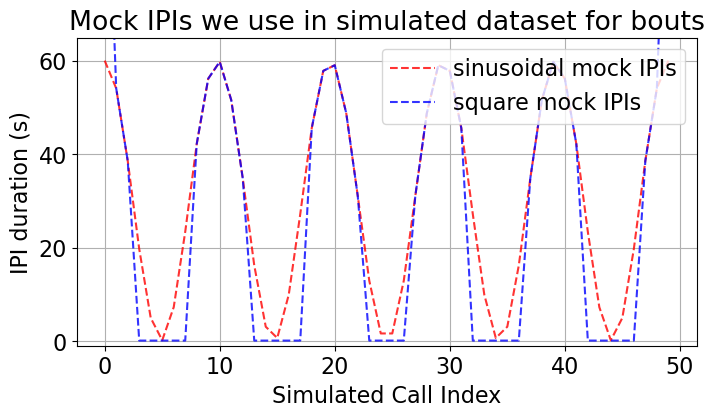

In [7]:
peak = 60
amplitude = (peak/2) - 0.05
b = (peak-amplitude)/amplitude
mock_sin_ipis = amplitude*(np.sin((np.linspace(0, 10*np.pi, 50)) + np.pi/2)+b)
mock_square_ipis = mock_sin_ipis.copy()
# mock_square_ipis[mock_square_ipis>(amplitude+20)] = amplitude*(1 + b)
mock_square_ipis[mock_square_ipis<peak-(30)] = amplitude*(-1 + b)
mock_square_ipis[mock_square_ipis==peak] = 120

plt.figure(figsize=(8, 4))
plt.rcParams.update({'font.size':16})
plt.title('Mock IPIs we use in simulated dataset for bouts')
plt.plot(mock_sin_ipis, color='red', alpha=0.8, linestyle='dashed', label='sinusoidal mock IPIs')
plt.plot(mock_square_ipis, color='blue', alpha=0.8, linestyle='dashed', label='square mock IPIs')
plt.grid(which='both')
plt.ylim(-1, (amplitude*2)+5)
plt.ylabel('IPI duration (s)')
plt.xlabel('Simulated Call Index')
plt.legend(loc='upper right')
plt.show()

In [8]:
mock_square_ipis[:50]

array([1.20000000e+02, 5.40523380e+01, 3.85716012e+01, 1.00000000e-01,
       1.00000000e-01, 1.00000000e-01, 1.00000000e-01, 1.00000000e-01,
       4.21732611e+01, 5.61459952e+01, 5.97541109e+01, 5.15645630e+01,
       3.48300169e+01, 1.00000000e-01, 1.00000000e-01, 1.00000000e-01,
       1.00000000e-01, 1.00000000e-01, 4.55758574e+01, 5.78111569e+01,
       5.90204811e+01, 4.87235196e+01, 3.10099447e+01, 1.00000000e-01,
       1.00000000e-01, 1.00000000e-01, 1.00000000e-01, 3.10099447e+01,
       4.87235196e+01, 5.90204811e+01, 5.78111569e+01, 4.55758574e+01,
       1.00000000e-01, 1.00000000e-01, 1.00000000e-01, 1.00000000e-01,
       1.00000000e-01, 3.48300169e+01, 5.15645630e+01, 5.97541109e+01,
       5.61459952e+01, 4.21732611e+01, 1.00000000e-01, 1.00000000e-01,
       1.00000000e-01, 1.00000000e-01, 1.00000000e-01, 3.85716012e+01,
       5.40523380e+01, 1.20000000e+02])

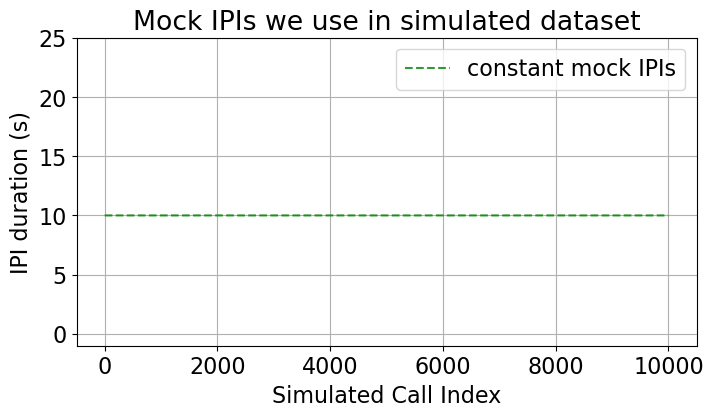

In [51]:
amplitude = 10
mock_constant_ipis = np.array([amplitude]*10000, dtype='float')

plt.figure(figsize=(8, 4))
plt.rcParams.update({'font.size':16})
plt.title('Mock IPIs we use in simulated dataset')
plt.plot(mock_constant_ipis, color='green', alpha=0.8, linestyle='dashed', label='constant mock IPIs')
plt.grid(which='both')
plt.ylim(-1, (amplitude*2)+5)
plt.ylabel('IPI duration (s)')
plt.xlabel('Simulated Call Index')
plt.legend(loc='upper right')
plt.show()

In [49]:
def create_initial_mock_data_from_ipis(ipis):
    mock_df = pd.DataFrame(columns=['ref_time', 'call_start_time', 'call_end_time', 'start_time', 'end_time', 'low_freq', 'high_freq'])
    ref_time = dt.datetime(2022, 6, 15, 3, 30, 0)
    for i in range(0, len(ipis)):
        start_time = ipis[:i+1].cumsum(axis=0)[-1]
        call_start_time = ref_time + dt.timedelta(seconds=start_time)
        call_end_time = ref_time + dt.timedelta(seconds=start_time+0.01)
        if call_end_time <= (ref_time+dt.timedelta(minutes=30)):
            mock_df.loc[i] = [ref_time, call_start_time, call_end_time, start_time, start_time+0.01, 20000, 30000]

    return mock_df

def group_frequencies_on_data(mock_df, data_params):
    groups = FREQ_GROUPS[data_params['site_tag']]
    blue_group = groups[list(groups.keys())[0]]
    red_group = groups[list(groups.keys())[1]]
    yellow_group = groups[list(groups.keys())[2]]

    call_is_yellow = (mock_df['low_freq']>=yellow_group[0])&(mock_df['high_freq']<=yellow_group[1])
    call_is_red = (mock_df['low_freq']>=red_group[0])&(mock_df['high_freq']<=red_group[1])
    call_is_blue = (mock_df['low_freq']>=blue_group[0])&(mock_df['high_freq']<=blue_group[1])

    mock_df.loc[call_is_yellow, 'freq_group'] = 'HF2'
    mock_df.loc[call_is_red&(~(call_is_yellow)), 'freq_group'] = 'HF1'
    mock_df.loc[call_is_blue&(~(call_is_red | call_is_yellow)), 'freq_group'] = 'LF1'

    for group in list(groups.keys()):
        freq_group_df = location_df.loc[location_df['freq_group']==group].copy()
        if len(freq_group_df)>0:
            dh.test_highest_freq_upper_bound(freq_group_df, groups[group])
            dh.test_lowest_freq_lower_bound(freq_group_df, groups[group])

    return mock_df

In [28]:
mock_bout_df = create_initial_mock_data_from_ipis(mock_square_ipis)
mock_bout_df = group_frequencies_on_data(mock_bout_df, data_params)
mock_bout_df = ss.simulate_dutycycle_on_detections(mock_bout_df, '1800of1800')
mock_bout_df

,start_time_wrt_ref,end_time_wrt_ref,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,freq_group
0,120.000000,120.010000,2022-06-15 03:30:00,2022-06-15 03:32:00.000000,2022-06-15 03:32:00.010000,120.000000,120.010000,20000,30000,LF1
1,174.052338,174.062338,2022-06-15 03:30:00,2022-06-15 03:32:54.052338,2022-06-15 03:32:54.062338,174.052338,174.062338,20000,30000,LF1
2,212.623939,212.633939,2022-06-15 03:30:00,2022-06-15 03:33:32.623939,2022-06-15 03:33:32.633939,212.623939,212.633939,20000,30000,LF1
3,212.723939,212.733939,2022-06-15 03:30:00,2022-06-15 03:33:32.723939,2022-06-15 03:33:32.733939,212.723939,212.733939,20000,30000,LF1
4,212.823939,212.833939,2022-06-15 03:30:00,2022-06-15 03:33:32.823939,2022-06-15 03:33:32.833939,212.823939,212.833939,20000,30000,LF1
5,212.923939,212.933939,2022-06-15 03:30:00,2022-06-15 03:33:32.923939,2022-06-15 03:33:32.933939,212.923939,212.933939,20000,30000,LF1
6,213.023939,213.033939,2022-06-15 03:30:00,2022-06-15 03:33:33.023939,2022-06-15 03:33:33.033939,213.023939,213.033939,20000,30000,LF1
7,213.123939,213.133939,2022-06-15 03:30:00,2022-06-15 03:33:33.123939,2022-06-15 03:33:33.133939,213.123939,213.133939,20000,30000,LF1
8,255.297200,255.307200,2022-06-15 03:30:00,2022-06-15 03:34:15.297200,2022-06-15 03:34:15.307200,255.297200,255.307200,20000,30000,LF1
9,311.443196,311.453196,2022-06-15 03:30:00,2022-06-15 03:35:11.443196,2022-06-15 03:35:11.453196,311.443196,311.453196,20000,30000,LF1


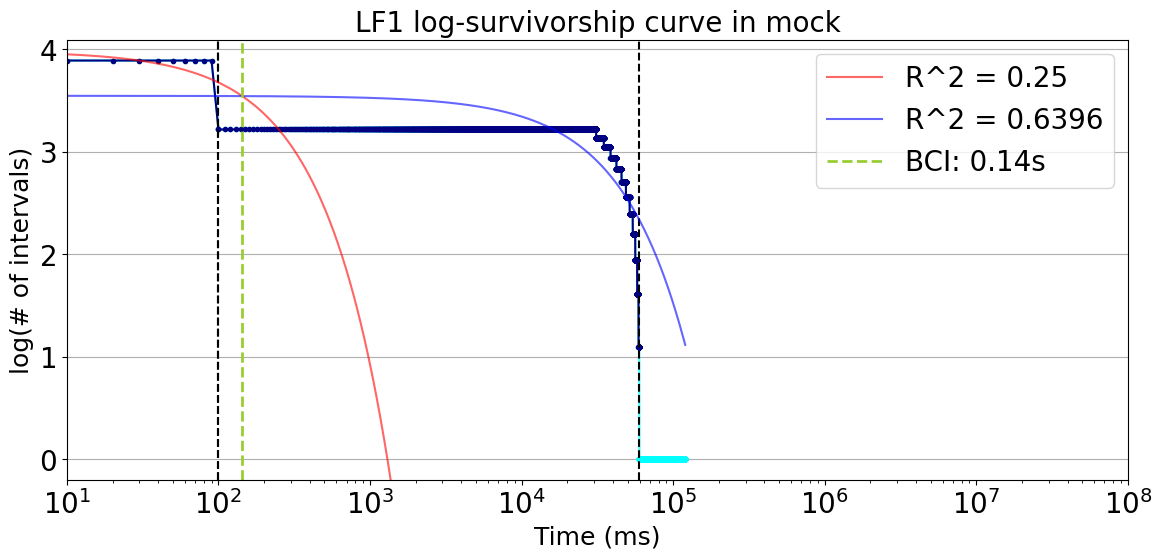

{'site_key': 'Carp', 'LF1_bci': 143.4164406635217}

In [29]:
bout_params = dict()
bout_params['site_key'] = data_params['site_tag']


group = 'LF1'
freq_group_df = mock_bout_df.loc[mock_bout_df['freq_group']==group].copy()
ipis_loc, hist_loc = bt_clustering.get_histogram(freq_group_df, 10)
intervals_ms, survival = bt_clustering.get_log_survival(hist_loc)
values = hist_loc[0]
max_val = np.max(values)
first_peak = np.where(values==max_val)[0][0]
fast_inds = range(0, int(np.ceil(1.1*first_peak))+1)
fast_coeff = stats.linregress(intervals_ms[fast_inds], survival[fast_inds])

fast_process = dict()
fast_process['metrics'] = fast_coeff
fast_process['indices'] = fast_inds
fast_process = bt_clustering.calculate_exponential_coefficients(fast_process)
slow_inds = np.logical_and(survival >= (survival.max() * 0.2), survival <= (survival.max() * 0.85)) 
slow_coeff = stats.linregress(intervals_ms[slow_inds], survival[slow_inds])

slow_process = dict()
slow_process['metrics'] = slow_coeff
slow_process['indices'] = slow_inds
slow_process = bt_clustering.calculate_exponential_coefficients(slow_process)
bci, misassigned_points = bt_clustering.get_bci_from_slater_method(fast_process, slow_process)
bt_plt.plot_bci_over_survival(intervals_ms, survival, fast_process, slow_process, bci, fig_details)
bout_params[f'{group}_bci'] = bci
bout_params

In [30]:
batdetect2_predictions = bt_clustering.classify_bouts_in_bd2_predictions_for_freqgroups(mock_bout_df, bout_params)
batdetect2_predictions

,call_status,change_markers,bout_tag,duration_from_last_call_ms,start_time_wrt_ref,end_time_wrt_ref,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,freq_group
0,outside bout,0.0,0,143.416443,120.000000,120.010000,2022-06-15 03:30:00,2022-06-15 03:32:00.000000,2022-06-15 03:32:00.010000,120.000000,120.010000,20000,30000,LF1
1,outside bout,0.0,0,54042.335938,174.052338,174.062338,2022-06-15 03:30:00,2022-06-15 03:32:54.052338,2022-06-15 03:32:54.062338,174.052338,174.062338,20000,30000,LF1
2,bout start,1.0,0,38561.597656,212.623939,212.633939,2022-06-15 03:30:00,2022-06-15 03:33:32.623939,2022-06-15 03:33:32.633939,212.623939,212.633939,20000,30000,LF1
3,within bout,0.0,1,90.000000,212.723939,212.733939,2022-06-15 03:30:00,2022-06-15 03:33:32.723939,2022-06-15 03:33:32.733939,212.723939,212.733939,20000,30000,LF1
4,within bout,0.0,1,90.000000,212.823939,212.833939,2022-06-15 03:30:00,2022-06-15 03:33:32.823939,2022-06-15 03:33:32.833939,212.823939,212.833939,20000,30000,LF1
5,within bout,0.0,1,90.000000,212.923939,212.933939,2022-06-15 03:30:00,2022-06-15 03:33:32.923939,2022-06-15 03:33:32.933939,212.923939,212.933939,20000,30000,LF1
6,within bout,0.0,1,90.000000,213.023939,213.033939,2022-06-15 03:30:00,2022-06-15 03:33:33.023939,2022-06-15 03:33:33.033939,213.023939,213.033939,20000,30000,LF1
7,bout end,-1.0,1,90.000000,213.123939,213.133939,2022-06-15 03:30:00,2022-06-15 03:33:33.123939,2022-06-15 03:33:33.133939,213.123939,213.133939,20000,30000,LF1
8,outside bout,0.0,0,42163.261719,255.297200,255.307200,2022-06-15 03:30:00,2022-06-15 03:34:15.297200,2022-06-15 03:34:15.307200,255.297200,255.307200,20000,30000,LF1
9,outside bout,0.0,0,56135.996094,311.443196,311.453196,2022-06-15 03:30:00,2022-06-15 03:35:11.443196,2022-06-15 03:35:11.453196,311.443196,311.453196,20000,30000,LF1


In [31]:
bout_metrics = bt_clustering.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_predictions)
bout_metrics

,freq_group,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,bout_duration,bout_duration_in_secs
0,LF1,2022-06-15 03:33:32.623939,2022-06-15 03:33:33.133939,212.623939,213.133939,212.623939,213.133939,20000,30000,0 days 00:00:00.510000,0.51
1,LF1,2022-06-15 03:37:37.591886,2022-06-15 03:37:38.101886,457.591886,458.101886,457.591886,458.101886,20000,30000,0 days 00:00:00.510000,0.51
2,LF1,2022-06-15 03:41:40.232846,2022-06-15 03:41:40.642846,700.232846,700.642846,700.232846,700.642846,20000,30000,0 days 00:00:00.410000,0.41
3,LF1,2022-06-15 03:45:42.773806,2022-06-15 03:45:43.283806,942.773806,943.283806,942.773806,943.283806,20000,30000,0 days 00:00:00.510000,0.51
4,LF1,2022-06-15 03:49:47.741753,2022-06-15 03:49:48.251753,1187.741753,1188.251753,1187.741753,1188.251753,20000,30000,0 days 00:00:00.510000,0.51


In [32]:
batdetect2_predictions.insert(0, 'call_durations', (batdetect2_predictions['call_end_time'] - batdetect2_predictions['call_start_time']))
df_resampled_every_30 = batdetect2_predictions.resample(f"{data_params['resolution_in_min']}T", on='ref_time')
num_of_detections = df_resampled_every_30['ref_time'].count()
num_of_detections

ref_time
2022-06-15 03:30:00    50
Freq: 30T, Name: ref_time, dtype: int64

In [16]:
shortest_call_per_30 = pd.to_numeric(df_resampled_every_30['call_durations'].min())/1e6
shortest_call_per_30

ref_time
2022-06-15 03:30:00    10.0
Freq: 30T, Name: call_durations, dtype: float64

In [17]:
max_allowable_calls_per_30 = np.abs(((int(data_params['resolution_in_min'])*60*60) / shortest_call_per_30))
max_allowable_calls_per_30

ref_time
2022-06-15 03:30:00    10800.0
Freq: 30T, Name: call_durations, dtype: float64

In [18]:
dh.test_number_of_detections_less_than_max_per_30(num_of_detections, max_allowable_calls_per_30)

In [19]:
bout_metrics['ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])
bout_metrics['total_bout_duration_in_secs'] = bout_metrics['bout_duration_in_secs']
bout_metrics = bout_metrics.set_index('ref_time')

bout_duration_per_interval = bout_metrics.resample(f"{data_params['resolution_in_min']}T")['total_bout_duration_in_secs'].sum()

time_occupied_by_bouts  = bout_duration_per_interval.values
percent_time_occupied_by_bouts = (100*(time_occupied_by_bouts / (60*float(data_params['resolution_in_min']))))
dh.test_bout_percentages_less_than_100(percent_time_occupied_by_bouts)

In [20]:
batdetect2_predictions['index_time'] = batdetect2_predictions['call_start_time']

temp = batdetect2_predictions.resample(f'{data_params["index_time_block_in_secs"]}S', on='index_time')['index_time'].count()
temp[temp>0] = 1
activity_indices = temp.resample(f"{data_params['resolution_in_min']}T").sum()
dh.test_activity_indices_less_than_max(activity_indices.values, data_params)
activity_indices

index_time
2022-06-15 03:30:00    26
Freq: 30T, Name: index_time, dtype: int64

## In mock data, the activity index is the # of calls outside bout + # of bouts
### This is because all bouts are smaller than 5-secs (time block length) so every bout = +1 activity index
### And because all outside bout calls are spaced 30-120 seconds from the bouts, each outside-bout call = +1 activity index

In [21]:
len(batdetect2_predictions.loc[batdetect2_predictions['call_status']=='outside bout']) + len(bout_metrics)

26

In [22]:
dc_tag = '1800of1800'
time_on = int(dc_tag.split('of')[0])
bt_clustering.test_bout_end_times_in_period(bout_metrics, time_on)

In [52]:
mock_subsampling_df = create_initial_mock_data_from_ipis(mock_constant_ipis)
mock_subsampling_df = group_frequencies_on_data(mock_subsampling_df, data_params)
ss.simulate_dutycycle_on_detections(mock_subsampling_df, '60of360')

,start_time_wrt_ref,end_time_wrt_ref,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,freq_group
0,10.0,10.01,2022-06-15 03:30:00,2022-06-15 03:30:10,2022-06-15 03:30:10.010,10.0,10.01,20000,30000,LF1
1,20.0,20.01,2022-06-15 03:30:00,2022-06-15 03:30:20,2022-06-15 03:30:20.010,20.0,20.01,20000,30000,LF1
2,30.0,30.01,2022-06-15 03:30:00,2022-06-15 03:30:30,2022-06-15 03:30:30.010,30.0,30.01,20000,30000,LF1
3,40.0,40.01,2022-06-15 03:30:00,2022-06-15 03:30:40,2022-06-15 03:30:40.010,40.0,40.01,20000,30000,LF1
4,50.0,50.01,2022-06-15 03:30:00,2022-06-15 03:30:50,2022-06-15 03:30:50.010,50.0,50.01,20000,30000,LF1
35,0.0,0.01,2022-06-15 03:36:00,2022-06-15 03:36:00,2022-06-15 03:36:00.010,360.0,360.01,20000,30000,LF1
36,10.0,10.01,2022-06-15 03:36:00,2022-06-15 03:36:10,2022-06-15 03:36:10.010,370.0,370.01,20000,30000,LF1
37,20.0,20.01,2022-06-15 03:36:00,2022-06-15 03:36:20,2022-06-15 03:36:20.010,380.0,380.01,20000,30000,LF1
38,30.0,30.01,2022-06-15 03:36:00,2022-06-15 03:36:30,2022-06-15 03:36:30.010,390.0,390.01,20000,30000,LF1
39,40.0,40.01,2022-06-15 03:36:00,2022-06-15 03:36:40,2022-06-15 03:36:40.010,400.0,400.01,20000,30000,LF1
